# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

In [53]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import pyprind
import time
import re
import nltk
from sklearn.feature_extraction import DictVectorizer
from collections import Counter

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [3]:
CONSUMER_KEY = "YZYvBWBTTtv1hVY3nQO01Itg2"
CONSUMER_SECRET = "Ot4K9jeWcKHGfy8PT26M0evvi6FFYELEu70v7HuGUKOypcEtv2"

ACCESS_TOKEN_KEY = "703233869185728512-Eor7lD2e8rFhFPnFMum9q9loPvIywLS"
ACCESS_TOKEN_SECRET = "TuLDuiXvtjsCgC8NNE1vNBQP72Lt2Bh8ceh68FjcW5reh"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [61]:
TMP_TWEET_RECORDS = "tmp_tweet_records.txt"
TARGET_FIELDS = ['lang', 'favorited', 'truncated', 'text', 'created_at', 'retweeted', 'source', 'user', 'id']
        
def get_user_tweets(user_id):
    try:
        time.sleep(api.GetSleepTime('statuses/user_timeline'))
    except:
        time.sleep(60)
        
    tweets = api.GetUserTimeline(user_id, count=200, include_rts=False, exclude_replies=True)
    result = [pd.Series(tweet.AsDict())[TARGET_FIELDS].to_dict() for tweet in tweets]
    for tweet in result:
        tweet['from_user'] = tweet['user']['id']
        tweet['user'] = user_id

    return result


def collect_tweets(uids, fast = True):
    tweet_records = []
    if os.path.exists(TMP_TWEET_RECORDS):
        with open(TMP_TWEET_RECORDS) as f:
            tweet_records = [json.loads(line) for line in f]
    tweet_users = set([tweet['user'] for tweet in tweet_records])
    
    if fast:
        return tweet_records
    
    f = open(TMP_TWEET_RECORDS, 'a')
    bar = pyprind.ProgBar(len(uids), width=100)
    
    for uid in uids:
        if uid not in tweet_users:
            try:
                user_tweets = get_user_tweets(uid)
                tweet_users.add(tweet['user'])
                for tweet in user_tweets:
                    f.write(json.dumps(tweet)+'\n')
                    tweet_records.append(tweet)

            except twitter.TwitterError as err:
                print 'Error in uid {0}. Loading defaults'.format(uid)
                tmp = {'user': uid, 'text': ''}
                f.write(json.dumps(tmp)+'\n')
                tweet_records.append(tmp)
                tweet_users.add(tmp['user'])
                
            except:
                f.close()
                raise
                
        bar.update()
        
    f.close()
    return tweet_records

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [45]:
def remove_replies(text):
    return re.sub(r"@\S+", '', text)

def remove_links(text):
    return re.sub(r'http\S+', '', text)

def get_words(text):
    text = remove_replies(text)
    text = remove_links(text)
    
    return [tok.strip() for tok in re.findall(r'#?[\w\d]+', text.lower()) if len(tok) > 2]

Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [13]:
# nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [71]:
def get_tokens(words):
    """returns list of tokens"""
    stop = nltk.corpus.stopwords.words('english')
    lemmatizer = nltk.WordNetLemmatizer()
    
    return [lemmatizer.lemmatize(word) for word in words if not word in stop]

Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [72]:
def get_tweet_tokens(tweet):
    stemmer = nltk.stem.porter.PorterStemmer()
    return [stemmer.stem(word) for word in get_tokens(tweet)]

In [116]:
def VectorizeTweets(tweets):
    summ = []
    for tweet in tweets:
        summ.extend(get_tweet_tokens(get_words(tweet)))
    
    return dict(Counter(summ))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [120]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    
    df = pd.DataFrame(collect_tweets(df_users['uid'], fast=False))
    grouped_res = df.groupby('user').apply(lambda x: VectorizeTweets(x['text']))
    
    return grouped_res.index, grouped_res.values

In [121]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

0%                                                                                                100%
[####################################################################################################] | ETA: 00:00:00
Total time elapsed: 00:00:02


In [125]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [311]:
from wordcloud import WordCloud
from PIL import Image

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    if random_state is None:
        random_state = Random()
    return "hsl(%d, 100%%, 30%%)" % random_state.randint(0, 255)

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    cloud_mask = np.array(Image.open("cloud_mask.png"))

    cloud_generator = WordCloud(
        background_color="white", 
        min_font_size=11, 
        max_words=300, 
        relative_scaling=1, 
        prefer_horizontal=0.7, 
        mask=cloud_mask, 
        color_func=random_color_func, 
        random_state=7)
    
    wordcloud = cloud_generator.generate_from_frequencies(zip(v.get_feature_names(), vs.sum(axis=0).tolist()[0]))
    
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    return

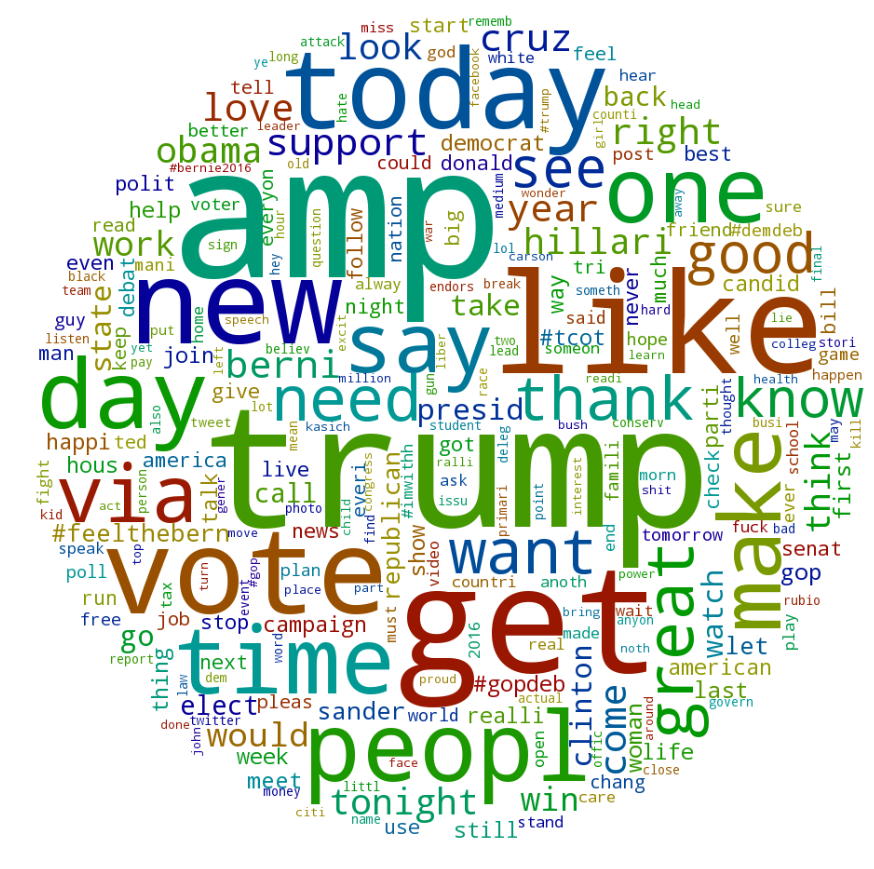

In [312]:
draw_tag_cloud(v, vs)